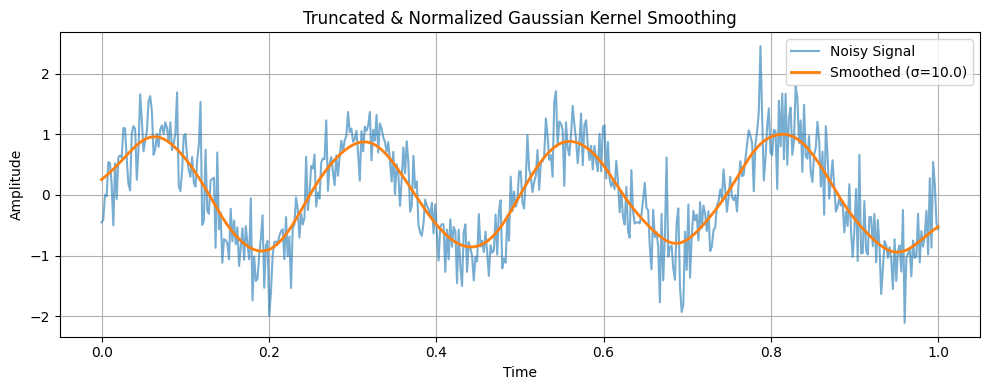

In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

def gaussian_kernel_1d(sigma, truncate=3.0, dtype=torch.float32, device='cpu'):
    radius = int(truncate * sigma + 0.5)
    x = torch.arange(-radius, radius + 1, dtype=dtype, device=device)
    kernel = torch.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()
    return kernel.view(1, 1, -1)

def gaussian_smooth_1d(y, sigma, truncate=3.0, eps=1e-8):
    if y.ndim == 1:
        y = y.unsqueeze(0)
    orig_shape = y.shape
    y = y.reshape(-1, 1, y.shape[-1])
    kernel = gaussian_kernel_1d(sigma, truncate, dtype=y.dtype, device=y.device)
    padding = (kernel.shape[-1] - 1) // 2
    num = F.conv1d(y, kernel, padding=padding)
    denom = F.conv1d(torch.ones_like(y), kernel, padding=padding)
    return (num / (denom + eps)).reshape(orig_shape)

# Generate a noisy signal
torch.manual_seed(0)
t = torch.linspace(0, 1, 500)
signal = torch.sin(8 * torch.pi * t) + 0.4 * torch.randn_like(t)

# Smooth it
sigma = 10.0
smoothed = gaussian_smooth_1d(signal, sigma)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, signal, label="Noisy Signal", alpha=0.6)
plt.plot(t, smoothed.squeeze().numpy(), label=f"Smoothed (σ={sigma})", linewidth=2)
plt.title("Truncated & Normalized Gaussian Kernel Smoothing")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


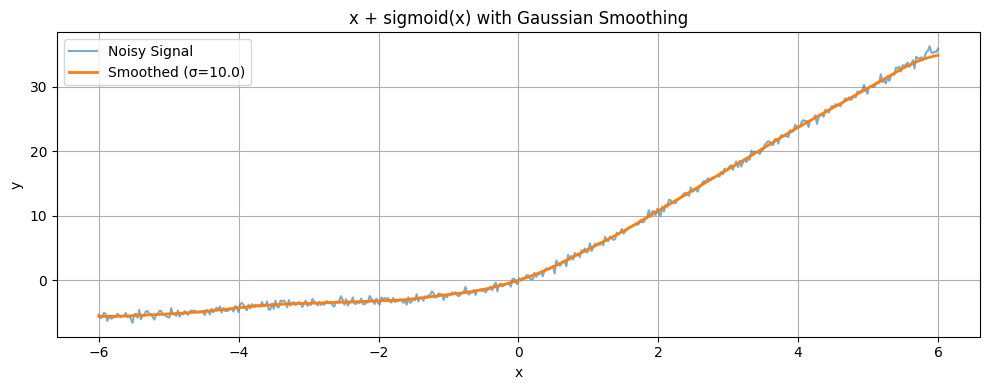

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Gaussian kernel generator
def gaussian_kernel_1d(sigma, truncate=3.0, dtype=torch.float32, device='cpu'):
    radius = int(truncate * sigma + 0.5)
    x = torch.arange(-radius, radius + 1, device=device, dtype=dtype)
    kernel = torch.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()
    return kernel.view(1, 1, -1)

# Smoother using conv1d
def gaussian_smooth_1d(y, sigma, truncate=3.0, eps=1e-8):
    if y.ndim == 1:
        y = y.unsqueeze(0)
    orig_shape = y.shape
    y = y.reshape(-1, 1, y.shape[-1])
    kernel = gaussian_kernel_1d(sigma, truncate, dtype=y.dtype, device=y.device)
    padding = (kernel.shape[-1] - 1) // 2
    num = F.conv1d(y, kernel, padding=padding)
    denom = F.conv1d(torch.ones_like(y), kernel, padding=padding)
    return (num / (denom + eps)).reshape(orig_shape)

# Generate x + sigmoid(x) + noise
np.random.seed(0)
x_np = np.linspace(-6, 6, 500)
y_np = x_np + x_np * 5 * 1 / (1 + np.exp(-x_np)) + 0.4 * np.random.randn(len(x_np))

x = torch.tensor(x_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

# Smooth it
sigma = 10.0
smoothed = gaussian_smooth_1d(y, sigma=sigma, truncate=3.0)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_np, y_np, label="Noisy Signal", alpha=0.6)
plt.plot(x_np, smoothed.squeeze().numpy(), label=f"Smoothed (σ={sigma})", linewidth=2)
plt.title("x + sigmoid(x) with Gaussian Smoothing")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
import numpy as np
import torch
import torch.nn.functional as F

def gaussian_kernel_1d(sigma, truncate=3.0):
    radius = int(truncate * sigma + 0.5)
    x = torch.arange(-radius, radius + 1)
    kernel = torch.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()
    return kernel.view(1, 1, -1)

def smooth_truncated(y, sigma, truncate=3.0, eps=1e-8):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    num = F.conv1d(y, kernel, padding=padding)
    denom = F.conv1d(torch.ones_like(y), kernel, padding=padding)
    return (num / (denom + eps)).squeeze()

def smooth_zero_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    return F.conv1d(y, kernel, padding=padding).squeeze()

def smooth_reflect_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    y_padded = F.pad(y, (padding, padding), mode='reflect')
    return F.conv1d(y_padded, kernel, padding=0).squeeze()

def ground_truth(x):
    return x + 5 * torch.sigmoid(x) * x * x**2

def evaluate_mse(n_iter=100000, sigma=1.0, truncate=3.0, noise_std=1.0):
    mse_trunc = []
    mse_zero = []
    mse_refl = []

    x = torch.linspace(-6, 6, 500)
    y_true = ground_truth(x)

    for _ in range(n_iter):
        noise = noise_std * torch.randn_like(x)
        y_noisy = y_true + noise

        mse_trunc.append(F.mse_loss(smooth_truncated(y_noisy, sigma, truncate), y_true).item())
        mse_zero.append(F.mse_loss(smooth_zero_pad(y_noisy, sigma, truncate), y_true).item())
        mse_refl.append(F.mse_loss(smooth_reflect_pad(y_noisy, sigma, truncate), y_true).item())

    print("MSE over 1000 iterations:")
    print(f"Truncated + Renormalized: {np.mean(mse_trunc):.6f}")
    # print(f"Zero Padding           : {np.mean(mse_zero):.6f}")
    print(f"Reflection Padding     : {np.mean(mse_refl):.6f}")

for i in range(0, 100):
    evaluate_mse(n_iter=1000, sigma=i/50)

MSE over 1000 iterations:
Truncated + Renormalized: nan
Reflection Padding     : nan
MSE over 1000 iterations:
Truncated + Renormalized: 0.999399
Reflection Padding     : 0.999399
MSE over 1000 iterations:
Truncated + Renormalized: 1.002683
Reflection Padding     : 1.002683
MSE over 1000 iterations:
Truncated + Renormalized: 0.998979
Reflection Padding     : 0.998979
MSE over 1000 iterations:
Truncated + Renormalized: 1.002822
Reflection Padding     : 1.002822
MSE over 1000 iterations:
Truncated + Renormalized: 0.995663
Reflection Padding     : 0.995663
MSE over 1000 iterations:
Truncated + Renormalized: 0.997156
Reflection Padding     : 0.997156
MSE over 1000 iterations:
Truncated + Renormalized: 1.000831
Reflection Padding     : 1.000831
MSE over 1000 iterations:
Truncated + Renormalized: 0.999672
Reflection Padding     : 0.999672
MSE over 1000 iterations:
Truncated + Renormalized: 1.000652
Reflection Padding     : 1.000651
MSE over 1000 iterations:
Truncated + Renormalized: 0.996961

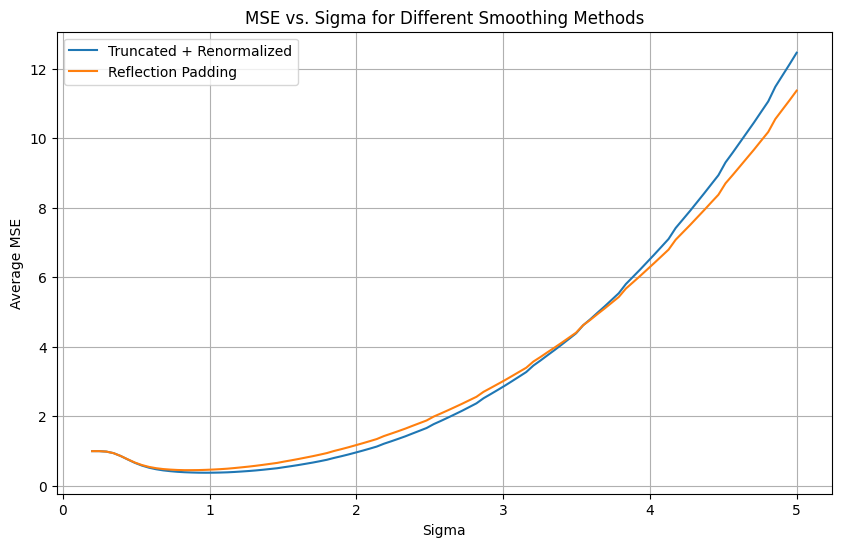

In [60]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def gaussian_kernel_1d(sigma, truncate=3.0):
    radius = int(truncate * sigma + 0.5)
    x = torch.arange(-radius, radius + 1)
    kernel = torch.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()
    return kernel.view(1, 1, -1)

def smooth_truncated(y, sigma, truncate=3.0, eps=1e-8):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    num = F.conv1d(y, kernel, padding=padding)
    denom = F.conv1d(torch.ones_like(y), kernel, padding=padding)
    return (num / (denom + eps)).squeeze()

def smooth_zero_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    return F.conv1d(y, kernel, padding=padding).squeeze()

def smooth_reflect_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    y_padded = F.pad(y, (padding, padding), mode='reflect')
    return F.conv1d(y_padded, kernel, padding=0).squeeze()

def ground_truth(x):
    return x + 5 * torch.sigmoid(x) * x * x**2

def evaluate_mse(n_iter, sigma, truncate=3.0, noise_std=1.0):
    x = torch.linspace(-6, 6, 500)
    y_true = ground_truth(x)

    mse_trunc, mse_zero, mse_refl = 0.0, 0.0, 0.0

    for _ in range(n_iter):
        noise = noise_std * torch.randn_like(x)
        y_noisy = y_true + noise

        mse_trunc += F.mse_loss(smooth_truncated(y_noisy, sigma, truncate), y_true).item()
        mse_zero += F.mse_loss(smooth_zero_pad(y_noisy, sigma, truncate), y_true).item()
        mse_refl += F.mse_loss(smooth_reflect_pad(y_noisy, sigma, truncate), y_true).item()

    return (
        mse_trunc / n_iter,
        mse_zero / n_iter,
        mse_refl / n_iter
    )

# Plot MSEs across sigmas
sigmas = np.linspace(0.2, 5.0, 100)
mse_trunc_list = []
mse_zero_list = []
mse_refl_list = []

for sigma in sigmas:
    mse_t, mse_z, mse_r = evaluate_mse(n_iter=10000, sigma=sigma)
    mse_trunc_list.append(mse_t)
    mse_zero_list.append(mse_z)
    mse_refl_list.append(mse_r)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigmas, mse_trunc_list, label="Truncated + Renormalized")
# plt.plot(sigmas, mse_zero_list, label="Zero Padding")
plt.plot(sigmas, mse_refl_list, label="Reflection Padding")
plt.xlabel("Sigma")
plt.ylabel("Average MSE")
plt.title("MSE vs. Sigma for Different Smoothing Methods")
plt.legend()
plt.grid(True)
plt.show()


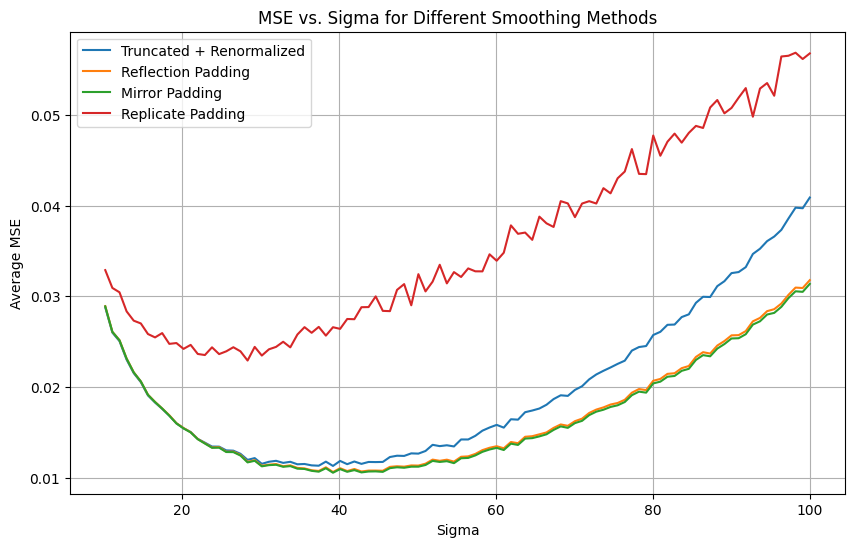

In [71]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def gaussian_kernel_1d(sigma, truncate=3.0):
    radius = int(truncate * sigma + 0.5)
    x = torch.arange(-radius, radius + 1)
    kernel = torch.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()
    return kernel.view(1, 1, -1)

def smooth_truncated(y, sigma, truncate=3.0, eps=1e-8):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    num = F.conv1d(y, kernel, padding=padding)
    denom = F.conv1d(torch.ones_like(y), kernel, padding=padding)
    return (num / (denom + eps)).squeeze()

def smooth_zero_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    return F.conv1d(y, kernel, padding=padding).squeeze()

def smooth_reflect_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    y_padded = F.pad(y, (padding, padding), mode='reflect')
    return F.conv1d(y_padded, kernel, padding=0).squeeze()

def smooth_mirror_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, N)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    # Manually create mirror padding (symmetric)
    left = y[..., 0:padding].flip(-1)
    right = y[..., -padding:].flip(-1)
    y_padded = torch.cat([left, y, right], dim=-1)
    return F.conv1d(y_padded, kernel, padding=0).squeeze()

def smooth_replicate_pad(y, sigma, truncate=3.0):
    y = y.unsqueeze(0).unsqueeze(0)
    kernel = gaussian_kernel_1d(sigma, truncate)
    padding = (kernel.shape[-1] - 1) // 2
    y_padded = F.pad(y, (padding, padding), mode='replicate')
    return F.conv1d(y_padded, kernel, padding=0).squeeze()

def ground_truth(x):
    # return x + 5 * torch.sigmoid(x) * x * x**2
    # return x + 5 * torch.sigmoid(x)
    return torch.sqrt(x + 7)

def evaluate_mse(n_iter, sigma, truncate=3.0, noise_std=1.0):
    x = torch.linspace(-6, 6, 500)
    y_true = ground_truth(x)

    mse_trunc, mse_zero, mse_refl, mse_mirror, mse_replicate = 0.0, 0.0, 0.0, 0.0, 0.0

    for _ in range(n_iter):
        noise = noise_std * torch.randn_like(x)
        y_noisy = y_true + noise

        mse_trunc += F.mse_loss(smooth_truncated(y_noisy, sigma, truncate), y_true).item()
        mse_zero += F.mse_loss(smooth_zero_pad(y_noisy, sigma, truncate), y_true).item()
        mse_refl += F.mse_loss(smooth_reflect_pad(y_noisy, sigma, truncate), y_true).item()
        mse_mirror += F.mse_loss(smooth_mirror_pad(y_noisy, sigma, truncate), y_true).item()
        mse_replicate += F.mse_loss(smooth_replicate_pad(y_noisy, sigma, truncate), y_true).item()

    return (
        mse_trunc / n_iter,
        mse_zero / n_iter,
        mse_refl / n_iter,
        mse_mirror / n_iter,
        mse_replicate / n_iter
    )

# Plot MSEs across sigmas
sigmas = np.linspace(10.2, 100.0, 100)
mse_trunc_list = []
mse_zero_list = []
mse_refl_list = []
mse_mirror_list = []
mse_replicate_list = []

for sigma in sigmas:
    mse_t, mse_z, mse_r, mse_m, mse_rep = evaluate_mse(n_iter=1000, sigma=sigma)
    mse_trunc_list.append(mse_t)
    mse_zero_list.append(mse_z)
    mse_refl_list.append(mse_r)
    mse_mirror_list.append(mse_m)
    mse_replicate_list.append(mse_rep)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigmas, mse_trunc_list, label="Truncated + Renormalized")
plt.plot(sigmas, mse_refl_list, label="Reflection Padding")
plt.plot(sigmas, mse_mirror_list, label="Mirror Padding")
plt.plot(sigmas, mse_replicate_list, label="Replicate Padding")
# Uncomment to show zero padding comparison
# plt.plot(sigmas, mse_zero_list, label="Zero Padding", linestyle='--', alpha=0.6)
plt.xlabel("Sigma")
plt.ylabel("Average MSE")
plt.title("MSE vs. Sigma for Different Smoothing Methods")
plt.legend()
plt.grid(True)
plt.show()


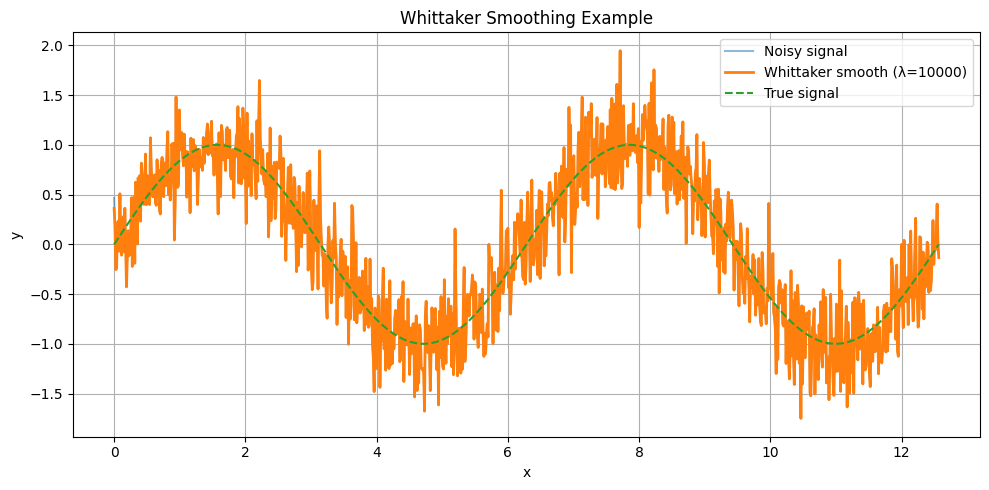

In [89]:
# Try again with minimal use of memory and simpler plotting to avoid MemoryError

import torch
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic noisy signal
n = 1000
x = torch.linspace(0, 4 * np.pi, n)
true_signal = torch.sin(x)
noise = 0.3 * torch.randn(n)
y_noisy = true_signal + noise

# Whittaker smoother implementation (order=2)
def whittaker_smooth(y, lam):
    n = y.shape[0]
    I = torch.eye(n)
    D = torch.zeros((n - 2, n))
    D[:, :-2] = D[:, :-2] + 1
    D[:, 1:-1] = D[:, 1:-1] - 2
    D[:, 2:] = D[:, 2:] + 1
    A = I + lam * D.T @ D
    smoothed = torch.linalg.solve(A, y)
    return smoothed

# Apply Whittaker smoothing
lam = 10000
y_smooth = whittaker_smooth(y_noisy, lam)

# Convert to NumPy for plotting
x_np = x.numpy()
y_noisy_np = y_noisy.numpy()
y_smooth_np = y_smooth.numpy()
true_signal_np = true_signal.numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_np, y_noisy_np, label="Noisy signal", alpha=0.5)
plt.plot(x_np, y_smooth_np, label=f"Whittaker smooth (λ={lam})", linewidth=2)
plt.plot(x_np, true_signal_np, label="True signal", linestyle='--')
plt.legend()
plt.title("Whittaker Smoothing Example")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.show()


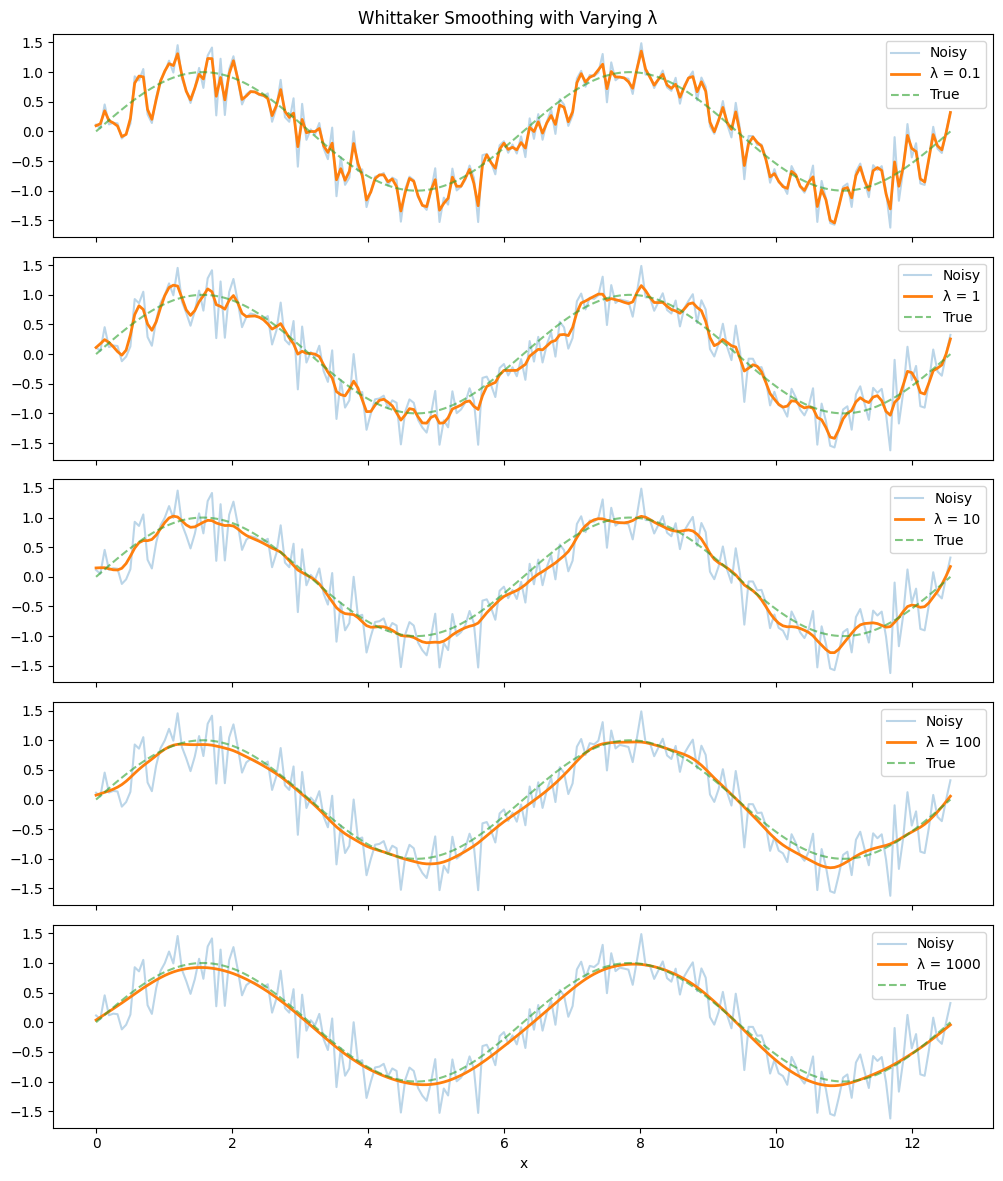

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def whittaker_smooth_np(y, lam):
    n = len(y)
    D = diags([1, -2, 1], [0, 1, 2], shape=(n-2, n))
    A = diags([1], [0], shape=(n, n)) + lam * (D.T @ D)
    return spsolve(A.tocsc(), y)

# Simulate signal
x = np.linspace(0, 4 * np.pi, 200)
true = np.sin(x)
y_noisy = true + 0.3 * np.random.randn(len(x))

# Try different lambdas
lambdas = [0.1, 1, 10, 100, 1000]
smoothed = [whittaker_smooth_np(y_noisy, lam) for lam in lambdas]

# Plot
fig, axs = plt.subplots(len(lambdas), 1, figsize=(10, 12), sharex=True)
for i, lam in enumerate(lambdas):
    axs[i].plot(x, y_noisy, alpha=0.3, label="Noisy")
    axs[i].plot(x, smoothed[i], label=f"λ = {lam}", linewidth=2)
    axs[i].plot(x, true, '--', label="True", alpha=0.6)
    axs[i].legend()
axs[-1].set_xlabel("x")
plt.suptitle("Whittaker Smoothing with Varying λ")
plt.tight_layout()
plt.show()


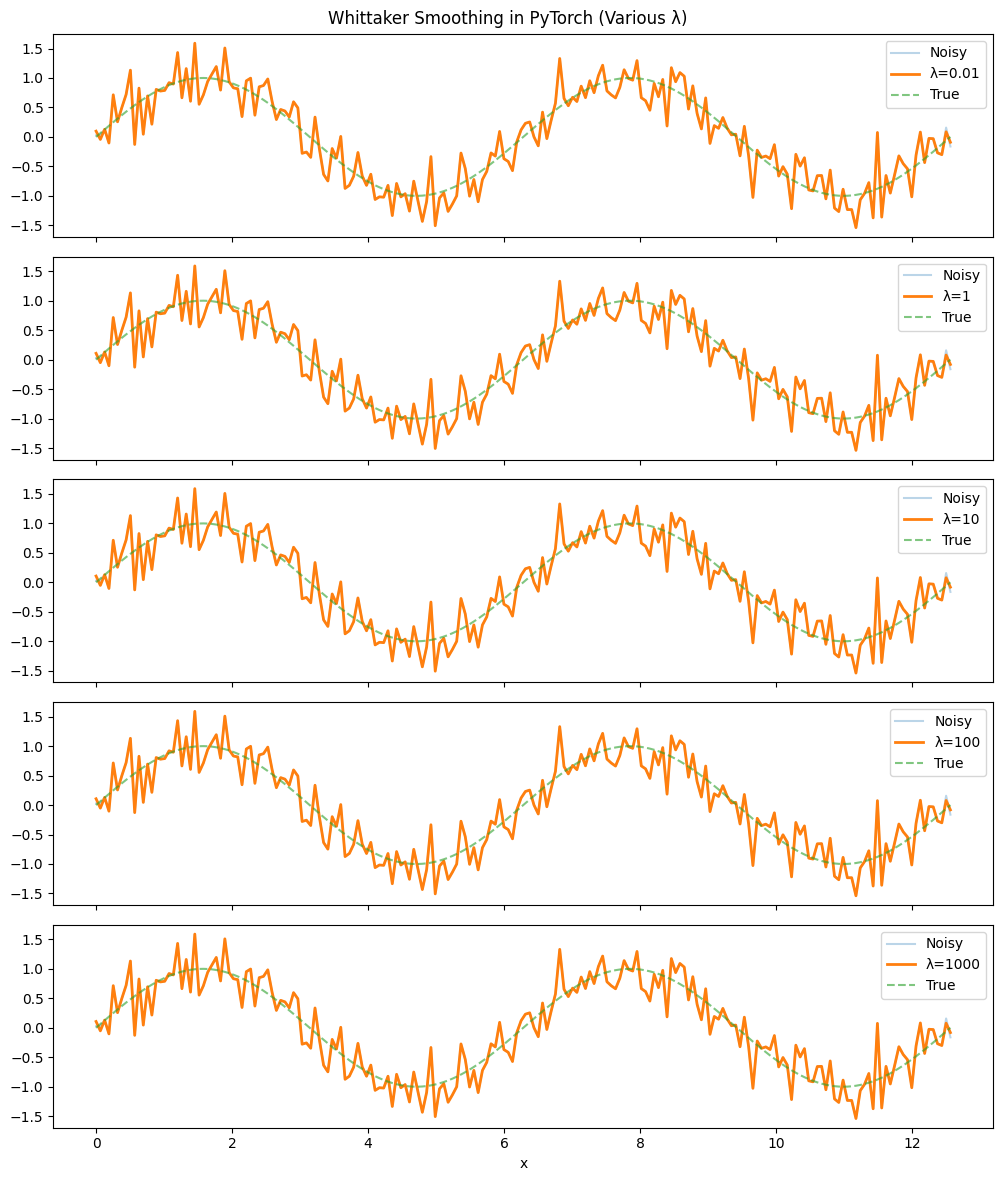

In [90]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def whittaker_smooth(y, lam):
    n = y.shape[0]
    I = torch.eye(n)
    D = torch.zeros((n - 2, n))
    D[:, :-2] += 1
    D[:, 1:-1] += -2
    D[:, 2:] += 1
    A = I + lam * D.T @ D
    return torch.linalg.solve(A, y)

# Generate noisy signal
n = 200
x = torch.linspace(0, 4 * np.pi, n)
true_signal = torch.sin(x)
y_noisy = true_signal + 0.3 * torch.randn(n)

# Sweep over lambdas
lambdas = [0.01, 1, 10, 100, 1000]
smoothed = [whittaker_smooth(y_noisy, lam) for lam in lambdas]

# Plot
x_np = x.numpy()
y_np = y_noisy.numpy()
true_np = true_signal.numpy()

fig, axs = plt.subplots(len(lambdas), 1, figsize=(10, 12), sharex=True)
for i, lam in enumerate(lambdas):
    axs[i].plot(x_np, y_np, label="Noisy", alpha=0.3)
    axs[i].plot(x_np, smoothed[i].numpy(), label=f"λ={lam}", linewidth=2)
    axs[i].plot(x_np, true_np, '--', label="True", alpha=0.6)
    axs[i].legend()
axs[-1].set_xlabel("x")
plt.suptitle("Whittaker Smoothing in PyTorch (Various λ)")
plt.tight_layout()
plt.show()


In [121]:
import torch

def whittaker_smooth(y: torch.Tensor, lam: float) -> torch.Tensor:
    if y.dim() == 1:
        y = y[None, :]                       # (1, n)

    B, n = y.shape
    lam = torch.as_tensor(lam, dtype=y.dtype, device=y.device) # type: ignore

    # main diagonal
    c = torch.ones(B, n, dtype=y.dtype, device=y.device)
    c[:, 0]  += lam
    c[:, 1]  += 5*lam
    c[:, 2:-2] += 6*lam
    c[:, -2] += 5*lam
    c[:, -1] += lam

    # lower diagonals
    b = torch.empty(B, n-1, dtype=y.dtype, device=y.device)
    b[:, 0]      = -2*lam
    b[:, 1:-1]   = -4*lam
    b[:, -1]     = -2*lam

    a = torch.full((B, n-2), lam, dtype=y.dtype, device=y.device)

    # upper diagonals (shifted)
    d = torch.empty_like(b)
    d[:, :-1] = b[:, 1:]
    d[:, -1]  = 0.

    e = torch.empty_like(a)
    e[:, :-1] = a[:, 1:]
    e[:, -1]  = 0.

    r = y.clone()

    # --- forward elimination ---
    for k in range(2, n):
        m = a[:, k-2] / c[:, k-2]
        c[:, k]   -= m * d[:, k-2]
        b[:, k-1] -= m * e[:, k-2]
        r[:, k]   -= m * r[:, k-2]

        m = b[:, k-1] / c[:, k-1]
        c[:, k]   -= m * d[:, k-1]
        if k < n-1:
            b[:, k] -= m * e[:, k-1]
        r[:, k]   -= m * r[:, k-1]

    # --- back substitution ---
    z = torch.empty_like(r)
    z[:, -1] = r[:, -1] / c[:, -1]
    z[:, -2] = (r[:, -2] - d[:, -2]*z[:, -1]) / c[:, -2]

    for k in range(n-3, -1, -1):
        z[:, k] = (r[:, k]
                   - d[:, k]*z[:, k+1]
                   - e[:, k]*z[:, k+2]) / c[:, k]

    return z.squeeze(0)


In [131]:
def whittaker_smooth(y: torch.Tensor, lam: float) -> torch.Tensor:
    if y.dim() == 1:
        y = y[None, :]
    B, n = y.shape
    lam  = torch.as_tensor(lam, dtype=y.dtype, device=y.device)

    # main, sub-1, sub-2
    c = torch.ones(B, n,        dtype=y.dtype, device=y.device)
    b = torch.empty(B, n-1,     dtype=y.dtype, device=y.device)
    a = torch.full((B, n-2), lam, dtype=y.dtype, device=y.device)

    c[:, 0]   += lam
    c[:, 1]   += 5*lam
    c[:, 2:-2] += 6*lam
    c[:, -2] += 5*lam
    c[:, -1] += lam

    b[:, 0]   = -2*lam
    b[:, 1:-1] = -4*lam
    b[:, -1]  = -2*lam

    d = b.clone()          # super-1   (will be *updated*)
    e = a.clone()          # super-2   (will be *updated*)
    r = y.clone()          # RHS

    # --- forward sweep (band-LU factorisation) ---
    for k in range(n-2):
        # 1-step elimination
        mu = b[:, k] / c[:, k]
        c[:, k+1] -= mu * d[:, k]
        if k+1 < n-1:
            b[:, k+1] -= mu * e[:, k]
            d[:, k+1] -= mu * a[:, k]      # *** new ***
        r[:, k+1] -= mu * r[:, k]

        # 2-step elimination
        mu2 = a[:, k] / c[:, k]
        c[:, k+2] -= mu2 * e[:, k]
        if k+2 < n-1:
            b[:, k+2] -= mu2 * a[:, k]     # *** new ***
        r[:, k+2] -= mu2 * r[:, k]

    # --- back substitution ---
    z = torch.empty_like(r)
    z[:, -1] = r[:, -1] / c[:, -1]
    z[:, -2] = (r[:, -2] - d[:, -2]*z[:, -1]) / c[:, -2]
    for k in range(n-3, -1, -1):
        z[:, k] = (r[:, k] - d[:, k]*z[:, k+1] - e[:, k]*z[:, k+2]) / c[:, k]

    return z.squeeze(0)


In [138]:
import torch

def whitaker_smooth(y: torch.Tensor, lam: float) -> torch.Tensor:
    """
    Whitaker smoother of order 2 in O(n) time using PyTorch.
    
    Args:
        y: Input 1D tensor (n,)
        lam: Smoothing parameter (lambda, larger = smoother)
    
    Returns:
        Smoothed 1D tensor of same shape as y.
    """
    n = y.shape[0]
    if y.ndim != 1:
        raise ValueError("Input y must be a 1D tensor.")

    # Create the diagonals for the banded system (tridiagonal)
    # System to solve: (I + λ * D^T D) * z = y
    # Where D is the second-order difference matrix
    diag = torch.ones(n, device=y.device)
    diag[2:] += lam * 6
    diag[1] += lam * 5
    diag[0] += lam

    lower = torch.zeros(n - 1, device=y.device)
    lower[1:] = -4 * lam
    lower[0] = -2 * lam

    upper = torch.zeros(n - 1, device=y.device)
    upper[:-1] = -4 * lam
    upper[-1] = -2 * lam

    # Forward elimination (Thomas algorithm)
    c_prime = torch.zeros(n - 1, device=y.device)
    d_prime = torch.zeros(n, device=y.device)

    c_prime[0] = upper[0] / diag[0]
    d_prime[0] = y[0] / diag[0]

    for i in range(1, n):
        denom = diag[i] - lower[i - 1] * c_prime[i - 1]
        if i < n - 1:
            c_prime[i] = upper[i] / denom
        d_prime[i] = (y[i] - lower[i - 1] * d_prime[i - 1]) / denom

    # Back substitution
    z = torch.zeros(n, device=y.device)
    z[-1] = d_prime[-1]
    for i in reversed(range(n - 1)):
        z[i] = d_prime[i] - c_prime[i] * z[i + 1]

    return z


In [139]:
x = torch.linspace(0, 4 * torch.pi, 2000)
y = torch.sin(x) + 0.3 * torch.randn_like(x)

z = whittaker_smooth(y, lam=1000)

print(torch.mean((y - z) ** 2))   # residual variance drops strongly


tensor(nan)


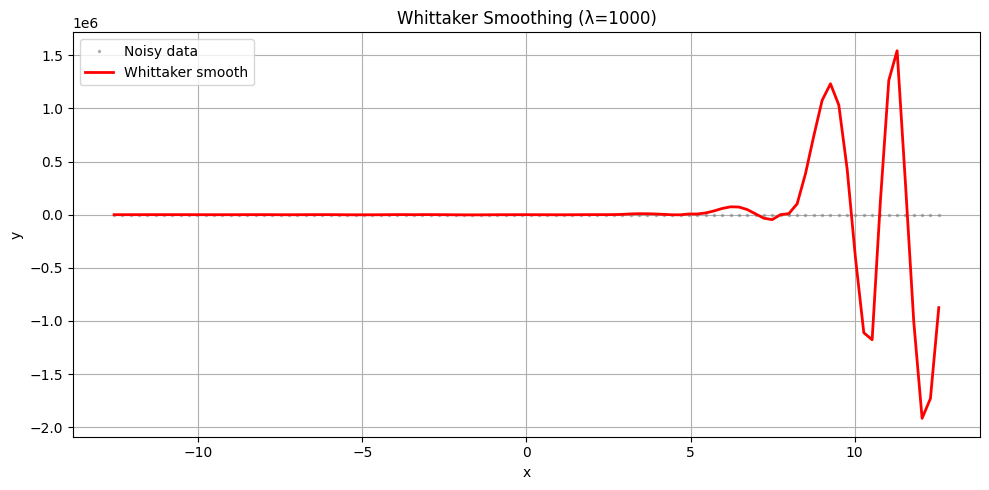

In [149]:
import torch
import matplotlib.pyplot as plt

# --- Signal setup ---
N = 100
x = torch.linspace(-4 * torch.pi, 4 * torch.pi, N)
true_func = x
noise = 0.0 * torch.randn(N)
y = true_func + noise

# --- Smooth the noisy signal ---
from torch import tensor
z = whittaker_smooth(y, lam=10.1)

# --- Plotting ---
plt.figure(figsize=(10, 5))
# plt.plot(x, true_func, label='True function (sin)', linewidth=2)
plt.plot(x, y, '.', color='gray', alpha=0.5, markersize=3, label='Noisy data')
plt.plot(x, z, color='red', label='Whittaker smooth', linewidth=2)

plt.title("Whittaker Smoothing (λ=1000)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
def reflect_pad(y: torch.Tensor, pad: int = 50):
    if y.ndim != 1:
        raise ValueError("Only 1D input supported for reflect_pad")

    if pad >= len(y) - 1:
        raise ValueError("Pad too large for input length")

    left = y[pad:0:-1]     # reversed [pad, 1]
    left = torch.cat((y[1:pad+1].flip(0),))  # safer alternative

    right = y[-2:-2-pad:-1]  # reversed [n-2, n-pad-1]
    right = torch.cat((y[-pad-1:-1].flip(0),))  # safer alternative

    return torch.cat([left, y, right])

pad = 100
y_pad = reflect_pad(y, pad=pad)
z_pad = whittaker_smooth(y_pad, lam=10000)
z = z_pad[pad:-pad]


ValueError: Pad too large for input length

In [152]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Generate fake data: y = 2x + 1 + noise
key = random.PRNGKey(0)
X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
true_w, true_b = 2.0, 1.0
noise = 0.1 * random.normal(key, X.shape)
y = true_w * X + true_b + noise

# Initialize parameters
params = {'w': jnp.array([0.0]), 'b': 0.0}

# Prediction function
def predict(params, x):
    return x @ params['w'] + params['b']

# Loss: Mean squared error
def loss_fn(params, x, y):
    preds = predict(params, x)
    return jnp.mean((preds - y) ** 2)

# Gradient function
loss_grad_fn = jit(grad(loss_fn))

# Training loop
learning_rate = 0.1
for epoch in range(100):
    grads = loss_grad_fn(params, X, y)
    params['w'] -= learning_rate * grads['w']
    params['b'] -= learning_rate * grads['b']
    if epoch % 10 == 0:
        loss = loss_fn(params, X, y)
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

print(f"Trained weights: {params}")


Epoch 0, Loss: 2.0234
Epoch 10, Loss: 1.3768
Epoch 20, Loss: 1.3694
Epoch 30, Loss: 1.3693
Epoch 40, Loss: 1.3693
Epoch 50, Loss: 1.3693
Epoch 60, Loss: 1.3693
Epoch 70, Loss: 1.3693
Epoch 80, Loss: 1.3693
Epoch 90, Loss: 1.3693
Trained weights: {'w': Array([3.2742251e-09], dtype=float32), 'b': Array(1.0109301, dtype=float32, weak_type=True)}


In [156]:
import jax
import jax.numpy as jnp
from typing import Optional

__all__ = ["whittaker_smooth"]

# -----------------------------------------------------------------------------
# Low‑level pentadiagonal solver (bandwidth 2)
# -----------------------------------------------------------------------------

def _pentadiagonal_solve(a: jnp.ndarray, b: jnp.ndarray, c: jnp.ndarray,
                         d: jnp.ndarray, e: jnp.ndarray,
                         y: jnp.ndarray) -> jnp.ndarray:
    """Solve A·x = y where *A* is symmetric penta‑diagonal.

    The diagonals are encoded following the convention::

        a[i] = A[i, i‑2]   (lower second)
        b[i] = A[i, i‑1]   (lower first)
        c[i] = A[i, i]     (main)
        d[i] = A[i, i+1]   (upper first)
        e[i] = A[i, i+2]   (upper second)

    Arrays *a*, *b*, *d*, *e* must be length *n* with the unused elements
    (``a[:2]``, ``b[:1]``, ``d[-1:]``, ``e[-2:]``) set to zero.
    The algorithm performs an O(n) Gaussian elimination specialised for the
    5‑diagonal case and is fully JIT‑compatible.
    """
    n = y.shape[0]

    # Forward elimination -----------------------------------------------------
    def fwd(i, vals):
        a, b, c, d, e, rhs = vals
        # Eliminate b[i+1]
        factor = b[i + 1] / c[i]
        c = c.at[i + 1].add(-factor * d[i])
        d = d.at[i + 1].add(-factor * e[i])
        rhs = rhs.at[i + 1].add(-factor * rhs[i])

        # Eliminate a[i+2]
        factor2 = a[i + 2] / c[i]
        b = b.at[i + 2].add(-factor2 * d[i])
        c = c.at[i + 2].add(-factor2 * e[i])
        rhs = rhs.at[i + 2].add(-factor2 * rhs[i])

        # Not strictly necessary, but zeros help numerical stability
        b = b.at[i + 1].set(0.0)
        a = a.at[i + 2].set(0.0)
        return a, b, c, d, e, rhs

    a, b, c, d, e, y2 = jax.lax.fori_loop(0, n - 2, fwd, (a, b, c, d, e, y))

    # Back substitution -------------------------------------------------------
    x = jnp.zeros_like(y2)
    x = x.at[n - 1].set(y2[n - 1] / c[n - 1])
    x = x.at[n - 2].set((y2[n - 2] - d[n - 2] * x[n - 1]) / c[n - 2])

    def back(k, val):
        # k runs 0 .. n‑3 ⇒ i = n‑3‑k
        x, yv, c_, d_, e_ = val
        i = n - 3 - k
        xi = (yv[i] - d_[i] * x[i + 1] - e_[i] * x[i + 2]) / c_[i]
        x = x.at[i].set(xi)
        return x, yv, c_, d_, e_

    x, *_ = jax.lax.fori_loop(0, n - 2, back, (x, y2, c, d, e))
    return x

# -----------------------------------------------------------------------------
# Utility to build the banded penalty matrix for d = 2
# -----------------------------------------------------------------------------

def _build_penalty_diagonals(n: int, lam: float):
    """Return the five diagonals of λ·DᵀD for *d* = 2 as (a, b, c, d, e)."""
    # Main diagonal -----------------------------------------------------------
    c = jnp.full((n,), 6.0)
    c = c.at[0].set(1.0)
    c = c.at[-1].set(1.0)
    if n > 1:
        c = c.at[1].set(5.0)
        c = c.at[-2].set(5.0)
    c = c * lam

    # First off diagonals -----------------------------------------------------
    b = jnp.full((n,), -4.0)
    b = b.at[0].set(-2.0)
    b = b.at[-1].set(-2.0)
    b = b * lam
    d = b  # symmetry

    # Second off diagonals ----------------------------------------------------
    a = jnp.zeros((n,)).at[2:].set(lam)
    e = jnp.zeros((n,)).at[:-2].set(lam)

    return a, b, c, d, e

# -----------------------------------------------------------------------------
# Public API
# -----------------------------------------------------------------------------

def whittaker_smooth(y: jnp.ndarray, lam: float, w: Optional[jnp.ndarray] = None) -> jnp.ndarray:
    """Whittaker smoother with second‑order difference penalty.

    This solves the penalised least squares problem

    .. math::
        \min_{z}\;\sum_{i} w_i (y_i - z_i)^2 + \lambda \sum_{i} (\Delta^2 z_i)^2

    in **O(n)** time using a specialised pentadiagonal solver.

    Parameters
    ----------
    y : (*n*,) array‑like
        Data vector to smooth.
    lam : float
        Non‑negative smoothing parameter :math:`\lambda`. Larger values yield
        a smoother result.
    w : (*n*,) array‑like, optional
        Non‑negative weights. If *None*, all weights are set to one.

    Returns
    -------
    z : (*n*,) jax.numpy.ndarray
        Smoothed values.
    """
    y = jnp.asarray(y)
    if y.ndim != 1:
        raise ValueError("`y` must be 1‑D. vmap over extra dimensions if needed.")

    n = y.shape[0]
    if w is None:
        w = jnp.ones_like(y)
    else:
        w = jnp.asarray(w)
        if w.shape != y.shape:
            raise ValueError("`w` must have the same shape as `y`.")

    # Build penalty matrix diagonals
    a, b, c, d, e = _build_penalty_diagonals(n, lam)

    # Add weights to the main diagonal
    c = c + w

    # Right‑hand side
    rhs = w * y

    # Solve (W + λ·DᵀD) z = W·y
    z = _pentadiagonal_solve(a, b, c, d, e, rhs)
    return z

# -----------------------------------------------------------------------------
# jit‑compile the public function for speed
# -----------------------------------------------------------------------------
whittaker_smooth = jax.jit(whittaker_smooth)


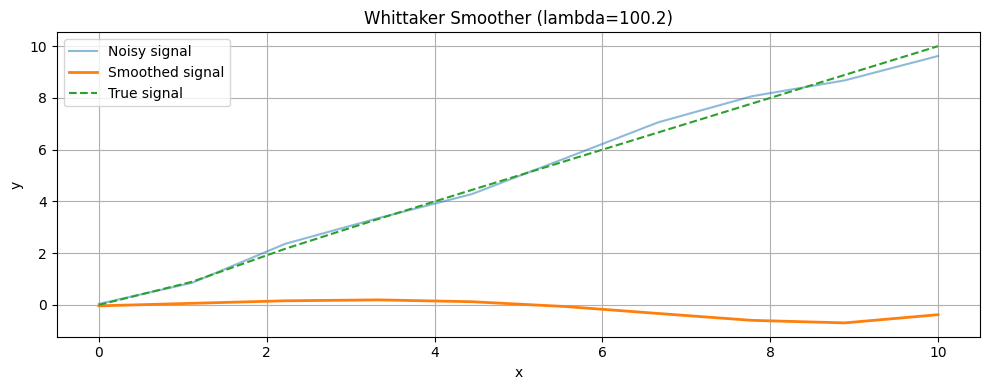

In [183]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np  # for reproducible random noise generation

# Generate noisy data
n = 10
x = jnp.linspace(0, 10, n)
true_y = x * jnp.tanh(x)
noise = jnp.array(np.random.default_rng(0).normal(0, 0.3, size=n))
y_noisy = true_y + noise

# Apply the Whittaker smoother
lambda_ = 100.2  # smoothing parameter
y_smooth = whittaker_smooth(y_noisy, lam=lambda_)

# Plot the result
plt.figure(figsize=(10, 4))
plt.plot(x, y_noisy, label='Noisy signal', alpha=0.5)
plt.plot(x, y_smooth, label='Smoothed signal', linewidth=2)
plt.plot(x, true_y, label='True signal', linestyle='--')
plt.legend()
plt.title(f"Whittaker Smoother (lambda={lambda_})")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.show()


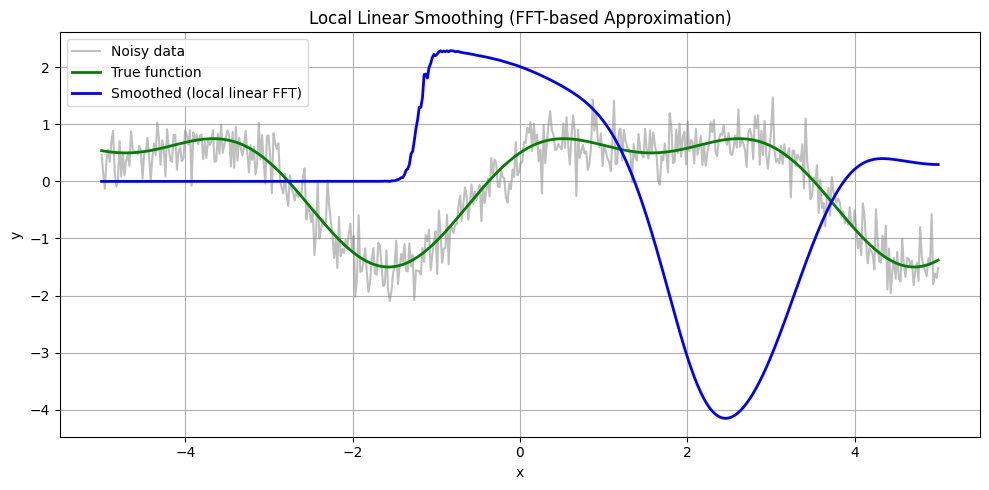

In [184]:
import torch
import torch.fft
import matplotlib.pyplot as plt
import numpy as np

# Gaussian kernel in 1D
def gaussian_kernel_1d(size, sigma):
    x = torch.arange(-size//2 + 1, size//2 + 1, dtype=torch.float32)
    kernel = torch.exp(-x**2 / (2 * sigma**2))
    return kernel / kernel.sum()

# Approximate local linear smoothing using FFT
def local_linear_smoother_fft(y, x, h):
    n = len(y)
    device = y.device
    x_centered = x - x.mean()
    
    # FFT-ready Gaussian kernel
    kernel = gaussian_kernel_1d(n, h).to(device)
    kernel_fft = torch.fft.fft(kernel, n=2*n)

    def conv(signal):
        signal_fft = torch.fft.fft(signal, n=2*n)
        return torch.real(torch.fft.ifft(signal_fft * kernel_fft))[:n]

    S0 = conv(torch.ones_like(y))
    S1 = conv(x_centered)
    S2 = conv(x_centered**2)
    Sy = conv(y)
    Sxy = conv(x_centered * y)

    denom = S0 * S2 - S1**2 + 1e-8
    beta0 = (S2 * Sy - S1 * Sxy) / denom
    return beta0

# Generate synthetic data
n = 512
x_np = np.linspace(-5, 5, n)
x = torch.tensor(x_np, dtype=torch.float32)
true_func = torch.sin(x) + 0.5 * torch.cos(2 * x)
noise = 0.3 * torch.randn(n)
y = true_func + noise

# Apply smoother
h = 20  # bandwidth in kernel space
y_smooth = local_linear_smoother_fft(y, x, h)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(x_np, y.numpy(), color='gray', alpha=0.5, label='Noisy data')
plt.plot(x_np, true_func.numpy(), color='green', label='True function', linewidth=2)
plt.plot(x_np, y_smooth.numpy(), color='blue', label='Smoothed (local linear FFT)', linewidth=2)
plt.legend()
plt.title("Local Linear Smoothing (FFT-based Approximation)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.show()


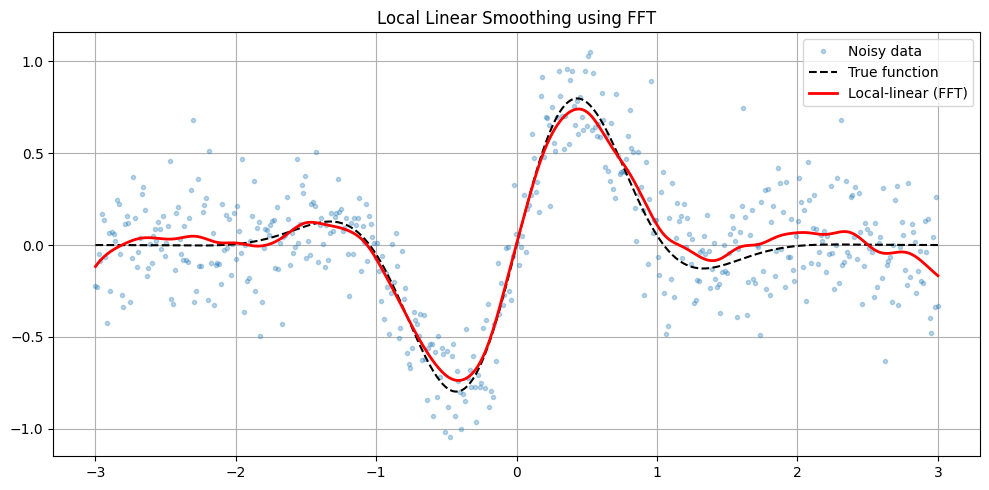

In [186]:
import torch
import matplotlib.pyplot as plt
from torchaudio.transforms import FFTConvolve

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Generate data
torch.manual_seed(0)
N = 512
x = torch.linspace(-3, 3, N, device=device)
true_fn = torch.sin(3 * x) * torch.exp(-x**2)
noise = 0.2 * torch.randn(N, device=device)
y = true_fn + noise

# 2. Set up kernel
h = 0.1                           # bandwidth
L = int(4 * h * N / 6)           # kernel half-width, 4 stddevs
grid = torch.arange(-L, L+1, device=device)
kernel = torch.exp(-0.5 * (grid / (h * N / 6))**2)
kernel /= kernel.sum()

# 3. Prepare basis vectors
idx = torch.arange(N, device=device)
idx2 = idx ** 2

# 4. Convolutions (local linear components)
fftconv = FFTConvolve(mode='same').to(device)

S0 = fftconv(torch.ones_like(y), kernel)
S1 = fftconv(idx.float(), kernel) - idx * S0
S2 = fftconv(idx2.float(), kernel) - 2 * idx * S1 - idx2 * S0

T0 = fftconv(y, kernel)
T1 = fftconv(y * idx, kernel) - idx * T0

den = S0 * S2 - S1**2 + 1e-12    # numerical stability
mhat = (S2 * T0 - S1 * T1) / den

# 5. Plot
plt.figure(figsize=(10, 5))
plt.plot(x.cpu(), y.cpu(), '.', alpha=0.3, label='Noisy data')
plt.plot(x.cpu(), true_fn.cpu(), 'k--', label='True function')
plt.plot(x.cpu(), mhat.cpu(), 'r', linewidth=2, label='Local-linear (FFT)')
plt.title('Local Linear Smoothing using FFT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


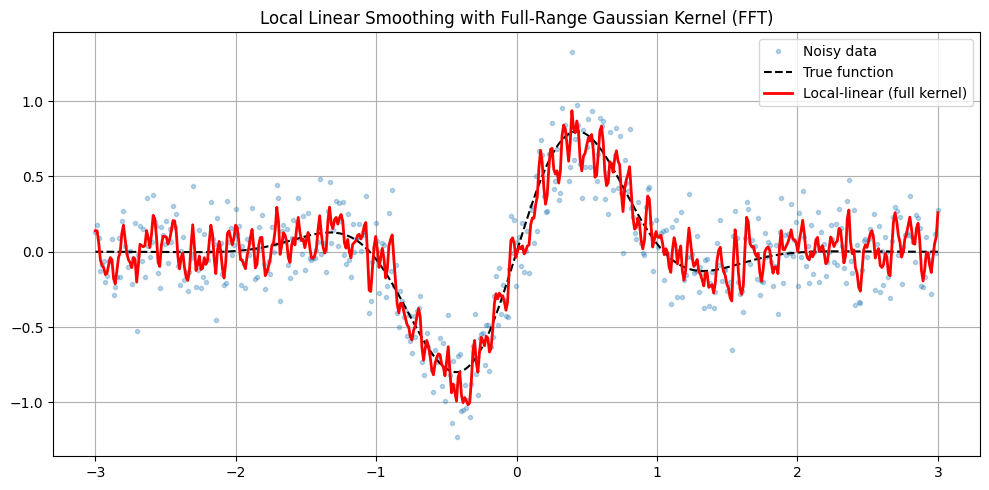

In [190]:
import torch
import matplotlib.pyplot as plt
from torchaudio.transforms import FFTConvolve

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generate data
N = 512
x = torch.linspace(-3, 3, N, device=device)
true_fn = torch.sin(3 * x) * torch.exp(-x**2)
y = true_fn + 0.2 * torch.randn(N, device=device)

# Bandwidth in x-units
h = 0.01

# Full-range kernel: cover the entire signal
dx = x[1] - x[0]                      # grid spacing
grid = torch.arange(-N+1, N, device=device)    # Full length (2N - 1)
kernel = torch.exp(-0.5 * ((grid * dx / h) ** 2))
kernel /= kernel.sum()               # Normalize

# FFT-based convolution module
fftconv = FFTConvolve(mode='same').to(device)

# Basis vectors
idx = torch.arange(N, device=device)
idx2 = idx**2

# Convolutions for local-linear smoother
S0 = fftconv(torch.ones_like(y), kernel)
S1 = fftconv(idx.float(), kernel) - idx * S0
S2 = fftconv(idx2.float(), kernel) - 2 * idx * S1 - idx2 * S0

T0 = fftconv(y, kernel)
T1 = fftconv(y * idx, kernel) - idx * T0

# Final smoothed estimate
den = S0 * S2 - S1**2 + 1e-12
mhat = (S2 * T0 - S1 * T1) / den

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x.cpu(), y.cpu(), '.', alpha=0.3, label='Noisy data')
plt.plot(x.cpu(), true_fn.cpu(), 'k--', label='True function')
plt.plot(x.cpu(), mhat.cpu(), 'r', linewidth=2, label='Local-linear (full kernel)')
plt.title('Local Linear Smoothing with Full-Range Gaussian Kernel (FFT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
